In [1]:
%cd ..

/Users/pedrobedmar/GoogleDrive/MASTER_BIG_DATA/tfm/code


In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from etl.esios.provider import ESIOSDataProvider
from etl.generic_provider import GenericDataProvider
import lab.functions as func

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor

SEED=0
np.random.seed(SEED)

In [3]:
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300

In [4]:
esios_provider = ESIOSDataProvider()
esios_tickers = esios_provider.get_tickers()
print(esios_tickers)

investingdotcom_tickers = ["DAILY_TTF_PRICE", "MONTHLY_TTF_PRICE"]
investingdotcom_provider = GenericDataProvider("datalake/clean/investingdotcom/", want_metadata=False, tickers=investingdotcom_tickers)
print(investingdotcom_tickers)

marketwatch_tickers = ["DAILY_COAL_PRICE"]
marketwatch_provider = GenericDataProvider("datalake/clean/marketwatch/", want_metadata=False, tickers=marketwatch_tickers)
print(marketwatch_tickers)

icap_tickers = ["CO2_EUA_PRICE"]
icap_provider = GenericDataProvider("datalake/clean/ICAP/", want_metadata=False, tickers=icap_tickers)
print(icap_tickers)

['DEMANDA_REAL', 'GENERACIÓN_MEDIDA_TOTAL', 'GENERACIÓN_MEDIDA_EÓLICA', 'GENERACIÓN_MEDIDA_HIDRÁULICA', 'GENERACIÓN_MEDIDA_NUCLEAR', 'GENERACIÓN_MEDIDA_SOLAR', 'GENERACIÓN_MEDIDA_CICLO_COMBINADO', 'GENERACIÓN_MEDIDA_CARBÓN', 'PRECIO_MERCADO_SPOT_DIARIO']
['DAILY_TTF_PRICE', 'MONTHLY_TTF_PRICE']
['DAILY_COAL_PRICE']
['CO2_EUA_PRICE']


In [5]:
forecasting_horizon = 12

nb_windows = 12
step_size = 1

lags = [2, 5, 6, 11, 12]
date_features = ["month", "year"]

regressor_list = [KNeighborsRegressor(), RandomForestRegressor(random_state=SEED, n_jobs=-1),
                      GradientBoostingRegressor(random_state=SEED)]
regressor_str_list = ["KNeighborsRegressor", "RandomForestRegressor", "GradientBoostingRegressor"]
save_path="lab/models_skforecast/monthly/"

In [6]:
def load_and_preprocess_daily_data(start_index, end_index, date_features):
    index_type = "DatetimeIndex"
    esios_spot = esios_provider.get_series("PRECIO_MERCADO_SPOT_DIARIO", index_type=index_type, freq="H", start_index=start_index, end_index=end_index, resample_by="M", group_mode="mean")
    esios_df = esios_provider.get_all_series(freq="H", index_type=index_type, start_index=start_index, end_index=end_index, resample_by="M", group_mode="sum")
    ttf_df = investingdotcom_provider.get_series(investingdotcom_tickers[1], freq="M", index_type=index_type, start_index=start_index, end_index=end_index)
    coal_df = marketwatch_provider.get_series(marketwatch_tickers[0], freq="D", index_type=index_type, start_index=start_index, end_index=end_index, resample_by="M", group_mode="mean")
    co2_df = icap_provider.get_series(icap_tickers[0], freq="D", index_type=index_type, start_index=start_index, end_index=end_index, resample_by="M", group_mode="mean")

    X = esios_df.drop(['PRECIO_MERCADO_SPOT_DIARIO', 'GENERACIÓN_MEDIDA_TOTAL'], axis=1)
    X = pd.concat([X, ttf_df, coal_df, co2_df], axis=1)
    lags = []

    df_date_features = func.add_date_features(esios_spot, X, lags, 1, date_features)

    data_train = df_date_features.iloc[:-forecasting_horizon, :].copy()
    data_test = df_date_features.iloc[-forecasting_horizon:, :].copy()

    initial_window_length = len(data_train) - step_size*(nb_windows-1)

    return data_train, data_test, initial_window_length

In [7]:
data_train, data_test, initial_window_length = load_and_preprocess_daily_data(start_index="2014-01-01", end_index="2023-03-31", date_features=date_features)
print(initial_window_length)

88


Model: KNeighborsRegressor
MASEs: [1.847172157047698, 1.9402408379557876, 2.5203743532667575, 2.595353659328698, 2.7924681262191644, 2.986892447331949, 3.123401036488765, 3.486116169931707]
MAEs: [9.289662937692382, 9.724414983561246, 12.772327329749103, 13.022174932262331, 13.889993323839391, 14.885454308009045, 15.581780426701334, 17.409485326104548]
Modelling time: 38.09944796562195

Model: RandomForestRegressor
MASEs: [1.421947607006334, 1.4872431850995027, 1.7825967894195391, 1.6317997425736523, 1.7340177698086565, 1.8427839673861535, 1.9625780106094588, 2.1291132725225643]
MAEs: [7.151154771225808, 7.454007580120069, 9.03354283934678, 8.187547629909927, 8.6251638899354, 9.183684056170405, 9.790756702176981, 10.632682466322445]
Modelling time: 38.41633701324463

Model: GradientBoostingRegressor
MASEs: [0.9483708253453624, 1.0392282827628998, 1.3493788151016448, 1.7793607275925047, 1.9326440055322167, 1.9922188929652067, 2.1150302627825863, 2.363631615560138]
MAEs: [4.7694771024918

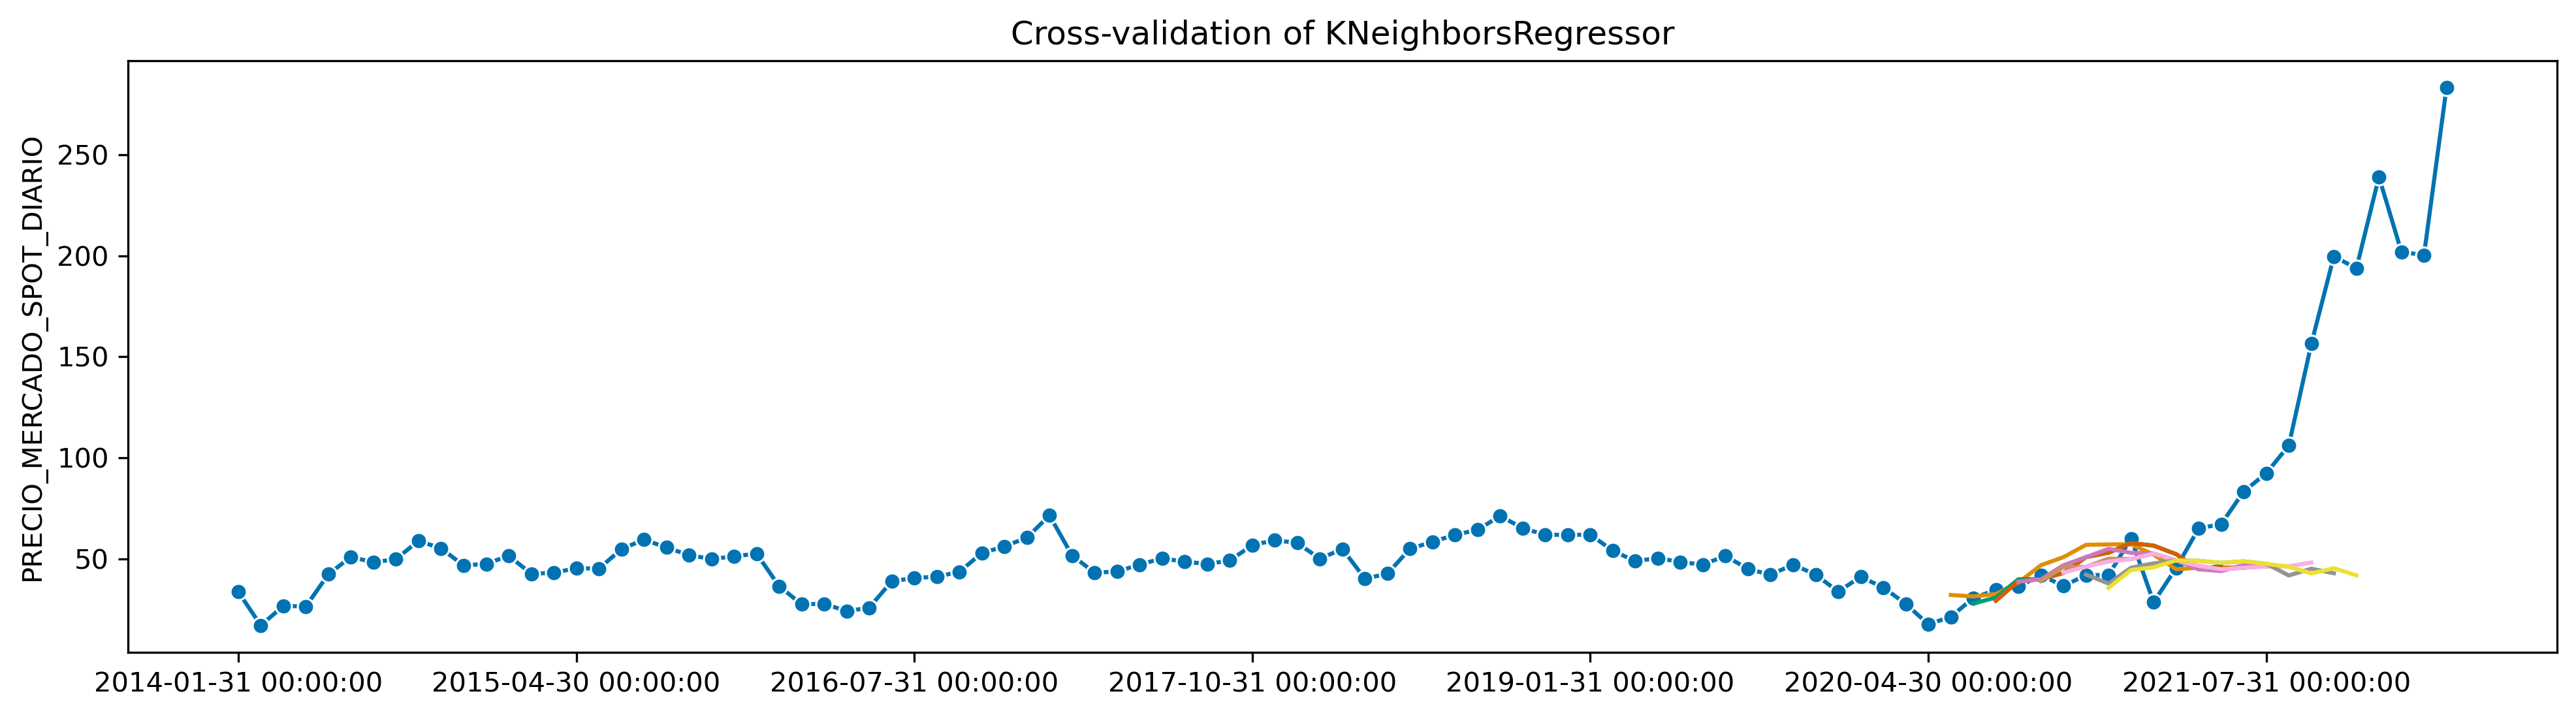

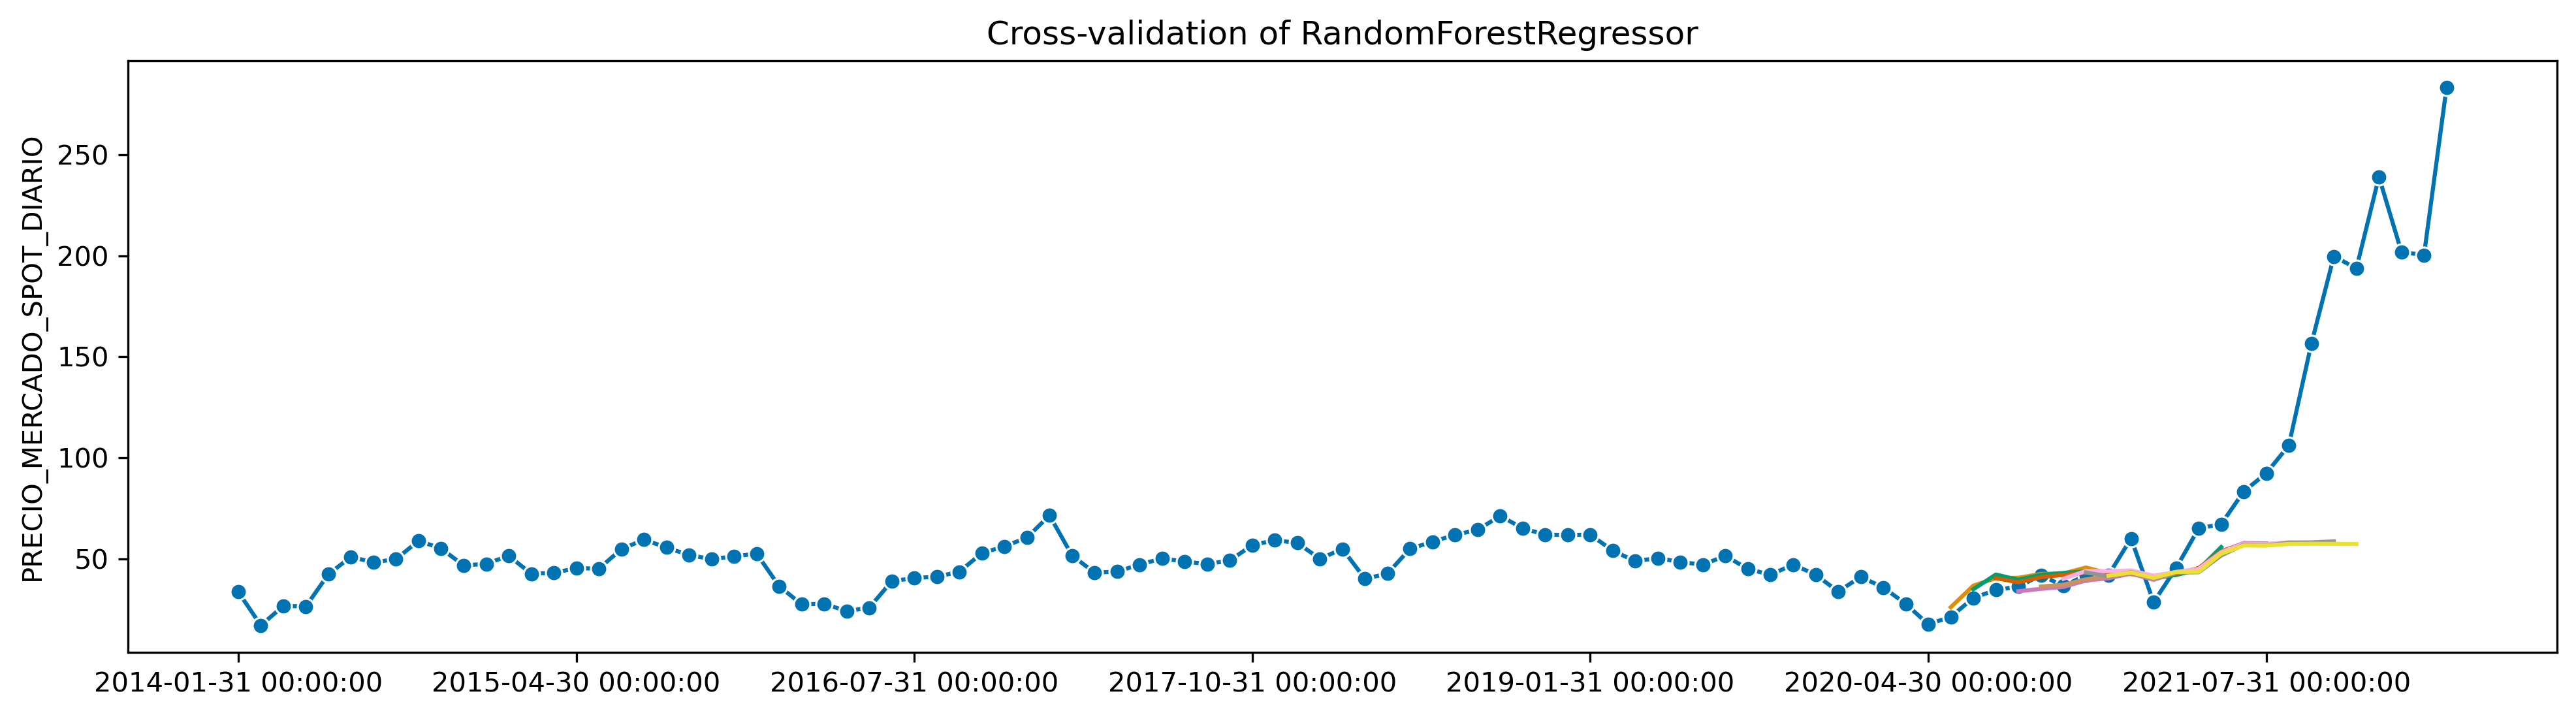

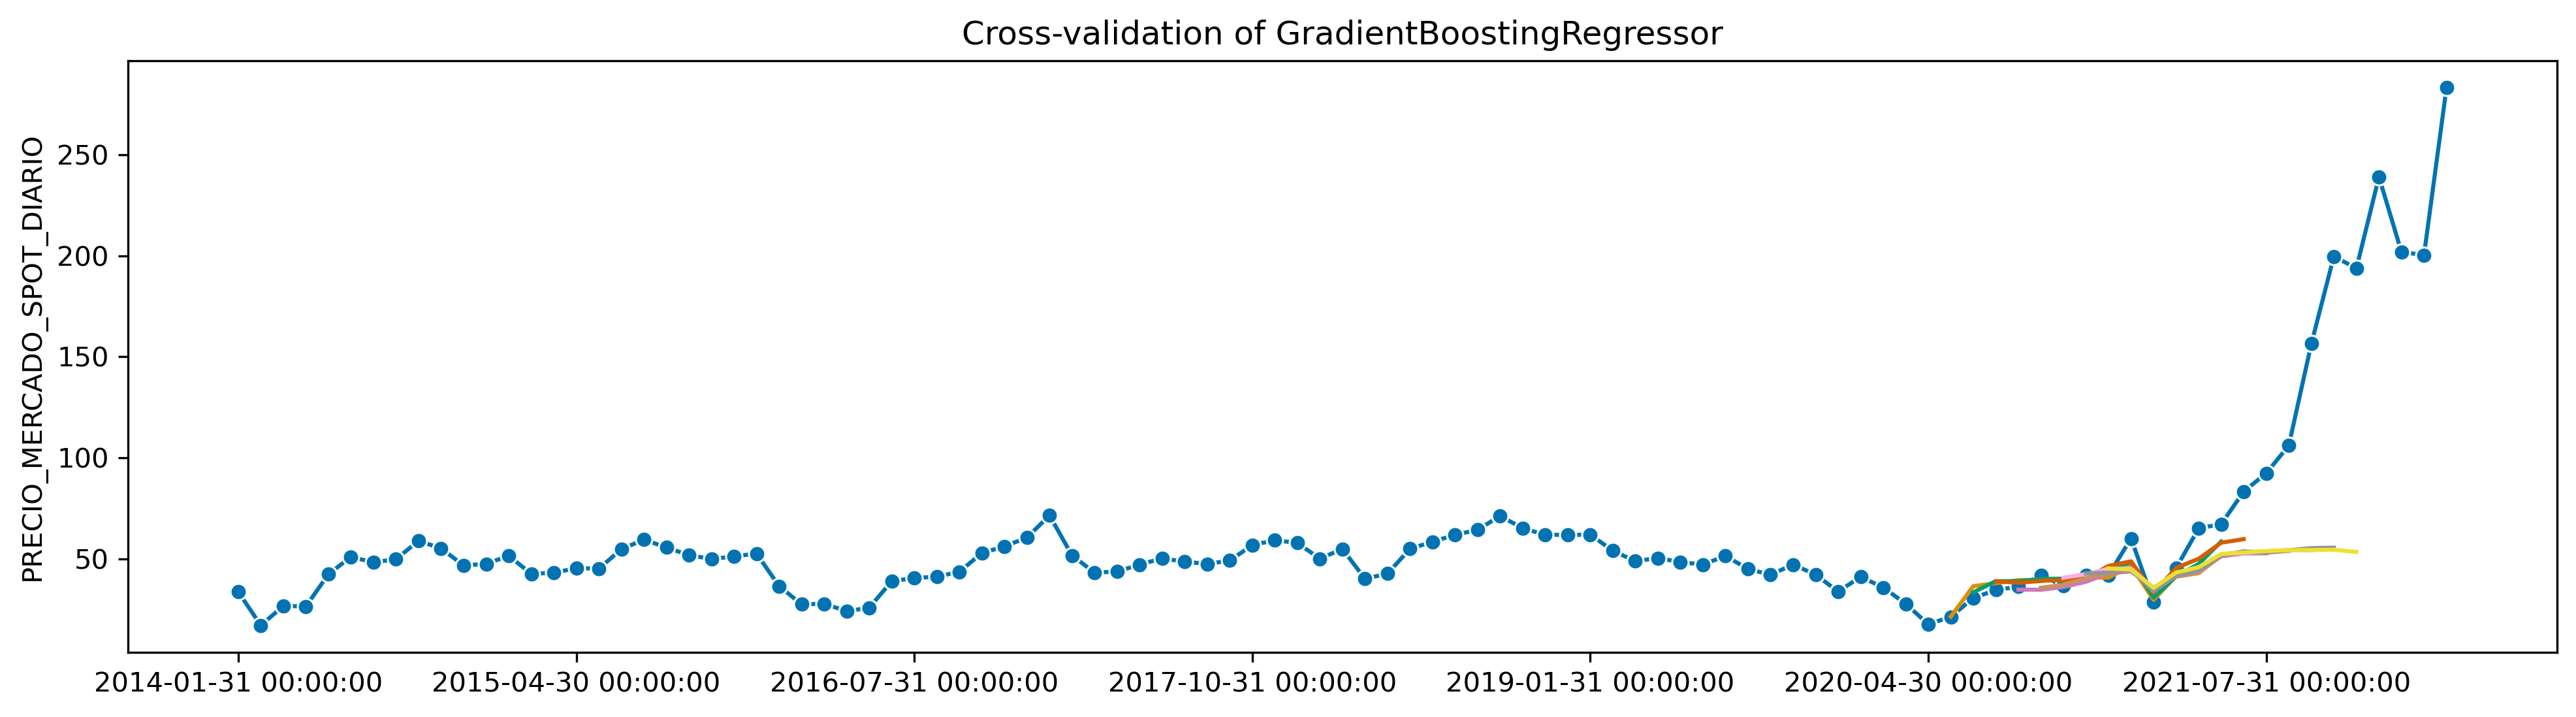

In [16]:
cv_results_df_summary = func.crossval_model_skforecast(data_train, regressor_list, regressor_str_list, initial_window_length, nb_windows, step_size, lags, date_features, forecasting_horizon)

In [17]:
cv_results_df_summary = cv_results_df_summary.sort_values("mean_mase")
cv_results_df_summary

,model,mean_mase,mean_mae,modelling_time
2,GradientBoostingRegressor,1.689983,8.455106,35.751275
1,RandomForestRegressor,1.749010,8.757317,38.416337
0,KNeighborsRegressor,2.661502,13.321912,38.099448


In [18]:
save_name="monthly.pkl"
os.makedirs(save_path, exist_ok=True)
cv_results_df_summary.to_pickle(save_path + save_name)

In [19]:
save_name="monthly.pkl"
cv_results_df_summary = pd.read_pickle(save_path+save_name)

### Final model

MASE: 7.346822674969767


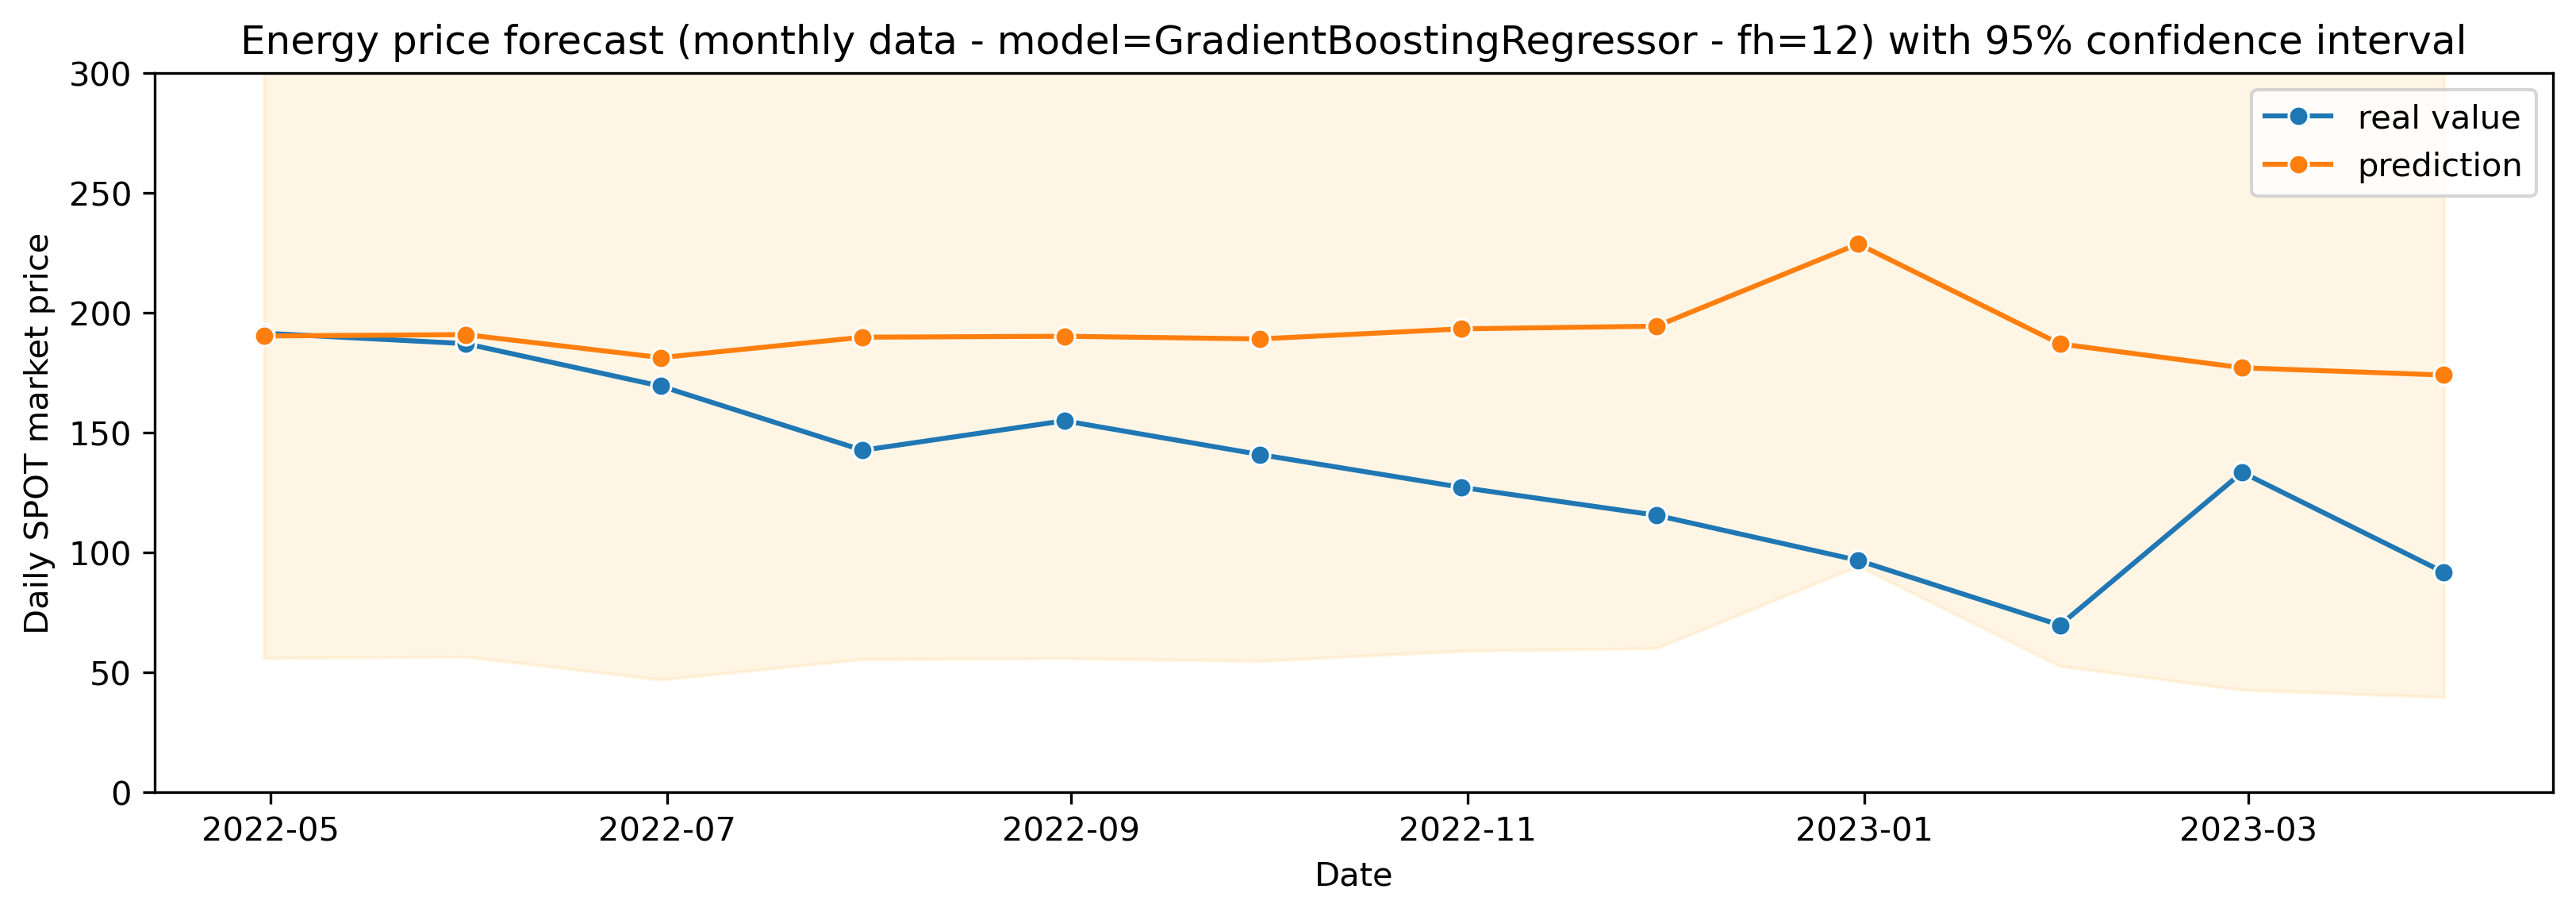

In [20]:
best_model_string = cv_results_df_summary.iloc[0, 0]
best_model = regressor_list[regressor_str_list.index(best_model_string)]
plot_lim = [0,300]
plot_title = f"Energy price forecast (monthly data - model={best_model_string} - fh={forecasting_horizon}) with 95% confidence interval"

func.final_model_skforecast(data_train, data_test, best_model, best_model_string, lags, date_features, forecasting_horizon, cv_results_df_summary, plot_lim, plot_title)